# Background

I used the following resources:
- Background
    - [Emipircal Evaluation of Gated Recurrent Neural Networks on Sequence Modeling](https://arxiv.org/pdf/1412.3555.pdf)
    - [Introduction to Sequence Models — RNN, Bidirectional RNN, LSTM, GRU](https://towardsdatascience.com/introduction-to-sequence-models-rnn-bidirectional-rnn-lstm-gru-73927ec9df15)
    - [Recurrent Neural Networks Introduction](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/recurrent_neural_networks.html)    
- Standford
    - [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)    
    - [Vector,Matrix and Tensor Derivatives Cheatsheet](http://cs231n.stanford.edu/vecDerivs.pdf)
- Vanilla
    - [Rnn (vanial, GRU and LSTM) from scratch](https://github.com/ankitesh97/NewsGenerator/blob/master/Gru.py)    

# Imports

In [1]:
import numpy as np

# Plotting
import matplotlib.pyplot as plt

%matplotlib inline
from IPython import display
plt.style.use('seaborn-white')

## Read and process data

The data to be learnt from is in the same directory as this notebook.  

In [2]:
data = open('input.txt', 'r').read()

Process data and calculate indexes

In [3]:
chars = list(set(data))
data_size, X_size = len(data), len(chars)
print("data has %d characters, %d unique" % (data_size, X_size))
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

data has 2421 characters, 42 unique


# Parameters

## Hyperparameters

In [4]:
H_size = 100 # Size of the hidden layer
T_steps = 25 # Number of time steps (length of the sequence) used for training
learning_rate = 1e-1 # Learning rate
z_size = H_size + X_size # Size of concatenate(H, X) vector

In [5]:
eps = 1e-8 # adagrad initialization note that this is usually between 1e-4 and 1e-8

## Constants

In [6]:
np.random.seed(64)

In [7]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / X_size) * T_steps

iteration, pointer = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

# Number of characters for the model to generate
numOfCharToGenerate = 100

# Number of iteration before showing the progress of the model
numOfIterToShowProgress = 200

# Number of iterations to use for training
numItr = 5000

## Model Parameters

In [8]:
class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value #parameter value
        self.d = np.zeros_like(value) #derivative
        self.m = np.zeros_like(value) #momentum for AdaGrad

We are initializing using the [Xavier initalization method](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf?hc_location=ufi). Which says that we multiply a random distribution with either

\begin{align}
\text{Var}(W) = \frac{1}{n_\text{in}}\\
\text{Var}(W) = \frac{2}{n_\text{in} + n_\text{out}}
\end{align}


In short, it helps signals reach deep into the network.

- If the weights in a network start too small, then the signal shrinks as it passes through each layer until it’s too tiny to be useful.
- If the weights in a network start too large, then the signal grows as it passes through each layer until it’s too massive to be useful.

Xavier initialization makes sure the weights are ‘just right’, keeping the signal in a reasonable range of values through many layers. To go any further than this, you’re going to need a small amount of statistics - specifically you need to know about random distributions and their variance.

For a detailed explanation refer to this [blog](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization) if the paper is too convoluted. We use the second implementation.

In [9]:
class Parameters:
    def __init__(self):
        # update gate
        self.W_u = Param('W_u', 
                         np.random.randn(H_size, z_size) * np.sqrt(2.0/(H_size+z_size)))
        self.b_u = Param('b_u',
                         np.zeros((H_size, 1)))
        
        # reset gate
        self.W_r = Param('W_r',
                         np.random.randn(H_size, z_size) * np.sqrt(2.0/(H_size+z_size)))
        self.b_r = Param('b_r',
                         np.zeros((H_size, 1)))
        
         # memory gate
        self.W_hbar = Param('W_har',
                         np.random.randn(H_size, z_size) * np.sqrt(2.0/(H_size+z_size)))
        self.b_hbar = Param('b_har',
                         np.zeros((H_size, 1)))        
        

        #For final layer to predict the next character
        self.W_v = Param('W_v',
                         np.random.randn(X_size, H_size) * np.sqrt(2.0/(X_size+H_size)))
        self.b_v = Param('b_v',
                         np.zeros((X_size, 1)))
        
    # this method makes it easier to loop through each paramters for either updating or clearing them out for initialization.    
    def all(self):
        return [self.W_u, self.W_r, self.W_hbar, self.W_v,
               self.b_u, self.b_r, self.b_hbar, self.b_v]
        
parameters = Parameters()

# Functions

## Activation Functions and Derivatives

### Sigmoid

\begin{align}
\sigma(x) &= \frac{1}{1 + e^{-x}}\\
\frac{d\sigma(x)}{dx} &= \sigma(x) \cdot (1 - \sigma(x))
\end{align}

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(y):
    return y * (1 - y)

### Tanh

\begin{align}
\frac{d\text{tanh}(x)}{dx} &= 1 - \text{tanh}^2(x)
\end{align}

In [11]:
def tanh(x):
    return np.tanh(x)

def dtanh(y):
    return 1 - y * y

## Forward pass

![GRU](https://i.imgur.com/HYMgdg9.png)

*Operation $z$ is the concatenation of $x$ and $h_{t-1}$*
and since we have two zeds I will associate the $z_t$ with $u_t$ for update state.

### Calculations
#### Concatenation of hprev and xt
\begin{align}
z & = [h_{t-1}, x_t] \\
\end{align}

#### LSTM functions
\begin{align}
u_t & = \sigma(W_u \cdot z + b_u) \\
r_t & = \sigma(W_r \cdot z + b_i) \\
\bar h_t & = tanh(W_{\bar h} \cdot [r_t * h_{t-1}, x_t])\\
h_t &= (1 - u_t) * h_{t-1} + u_t * \bar h_t \\
\end{align}

#### Logits
\begin{align}
v_t &= W_v \cdot h_t + b_v \\
\end{align}

#### Softmax
\begin{align}
\hat{y_t} &= \text{softmax}(v_t)
\end{align}

$\hat{y_t}$ is `y` in code and $y_t$ is `targets`.


### forward()

Just go through the computational graph.

In [12]:
def forward(x, h_prev, p = parameters):
    assert x.shape == (X_size, 1)
    assert h_prev.shape == (H_size, 1)    
    
    # concatontae hiddenstate matrix with the input matrix to make calculatations cleaner
    z = np.row_stack((h_prev, x))
    
    # calculate LSTM gates 
    u = sigmoid(np.dot(p.W_u.v, z) + p.b_u.v)
    r = sigmoid(np.dot(p.W_r.v, z) + p.b_r.v)
    
    z_prime = np.row_stack((r*h_prev, x))
    hbar = tanh(np.dot(p.W_hbar.v, z_prime) + p.b_hbar.v)
        
    
    # hidden state for this tick    
    h = (1-u)*h_prev + u*hbar
    
    # softmax loss
    v = np.dot(p.W_v.v, h) + p.b_v.v
    y = np.exp(v) / np.sum(np.exp(v)) #softmax

    return z, u, r, z_prime, hbar, h, v, y

### Backward pass

#### Loss

\begin{align}
L_k &= -\sum_{t=k}^T\sum_j y_{t,j} log \hat{y_{t,j}} \\
L &= L_1 \\
\end{align}

#### Gradients
Follow the gradient backwards through the computational graphs.  Same as the LSTM.

The most important thing to note here is the junction cases.  At these points add all the in coming gradients together before going upstream.  Apart from that there is nothing really tricky about this.

### backward()

Note: When traversing through the computational network to get the local gradient of a node it is [**upstream**] * [**downstream**]

- **add gate:** gradient distributer ... pass the exact same value through each of the branches
- **max gate:** gradient router ... passes the entire upstream gradient to the branch with the highest upstream value
- **mul gate:** gradient switcher ... local gradient is the value of the other branch (think of this a s ad/dx of a linear function)
- **functional gate:** gradient of the function ... take the derivative of this function with respect to the upstream

In [13]:
def backward(target, dh_next, h_prev,
             z, u, r, z_prime, hbar, h, v, y,
             p = parameters):
    
    assert z.shape == (X_size + H_size, 1)
    assert v.shape == (X_size, 1)
    assert y.shape == (X_size, 1)
    
    for param in [dh_next, u, r, hbar, h]:
        assert param.shape == (H_size, 1)
    
    # Loss function
    dv = np.copy(y)
    dv[target] -= 1
    
    # Loss function wrt logit
    p.W_v.d += np.dot(dv, h.T)
    p.b_v.d += dv
    
    # logit wrt hidden state
    # NOTE: from here on dh is common in the calculations for all the weights
    dh = np.dot(p.W_v.v.T, dv)        
    dh += dh_next
    
    
    # calculate the affects of the ---------------------  update gate    
    # backprop throught he add gate which is just a distributer
    # backprop through the -1 which just multiplies dh by -1
    # add hbar because there is a junction 
    du = dh * -1 * h_prev + hbar
    # backprop through the sigmoid gate
    du = dsigmoid(u) * du
    # backprop through the final mul gate
    p.W_u.d += np.dot(du, z.T)
    p.b_u.d += du   
    
    # calculate the affects of the ---------------------  reset gate    
    # backprop through the mul gate
    # add hprev because of the junction
    dr = dh * (1 - u) + h_prev
    # bcakprop through the mul gate
    dr = dr * z_prime[:H_size, :]
    # backprop through the sigmoid
    dr = dsigmoid(r) * dr
    # backpropr through the final mul gate
    p.W_r.d += np.dot(dr, z.T)
    p.b_r.d += dr   
    
    # calculate the affects of the ---------------------  memory gate    
    # backprop through the mul gate
    dhbar = dh * u
    # backprop through the tanh gate
    dhbar = dtanh(hbar) * dhbar
    # backprop through the final mul gate but with z_prime
    dhbar = dhbar + z_prime[:H_size, :]
    # backpropr through the final mul gat but with 
    p.W_hbar.d += np.dot(dhbar, z.T)
    p.b_hbar.d += dhbar    
    
    
    # calculate the affects of the ---------------------- z weigths
    dz = (np.dot(p.W_u.v.T, du)
         + np.dot(p.W_r.v.T, dr)         
         + np.dot(p.W_hbar.v.T, dhbar))
    
    # only take the portion of the input that is affected by the hidden states.  Recall that z is a concatination of the
    # hidden state and the input one hot vector
    dh_prev = dz[:H_size, :]
       
    
    return dh_prev

## Utility Functions

### Clear gradients 
Used for initialization 

In [14]:
def clear_gradients(params = parameters):
    for p in params.all():
        p.d.fill(0)

### Clip gradients 
This is to mitigate exploding gradients

In [15]:
def clip_gradients(params = parameters):
    # clip the crapids to [-1,1]
    for p in params.all():
        np.clip(p.d, -5, 5, out=p.d)

### Forward-Backward

Perform forward and then back prop in one function to keep things nice and tidy when reading the main LSTM loop

In [16]:
def forward_backward(inputs, targets, h_prev):
    global paramters
    
    # To store the values for each time step
    x_s, z_s, u_s, r_s,  = {}, {}, {}, {}
    z_prime_s = {}
    hbar_s, h_s = {}, {}
    v_s, y_s =  {}, {}
    
    # Values at t - 1
    h_s[-1] = np.copy(h_prev)    
    
    loss = 0
    # Loop through time steps
    assert len(inputs) == T_steps
    for t in range(len(inputs)):
        
        # one hot encode the input vector
        x_s[t] = np.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1 # Input character
        
        # Forward pass
        (z_s[t], u_s[t], r_s[t],
        z_prime_s[t], hbar_s[t], 
         h_s[t], v_s[t], y_s[t]) = \
            forward(x_s[t], h_s[t - 1],parameters) 
        
        # Loss for this tick
        loss += -np.log(y_s[t][targets[t], 0]) 
    
    # clear the gradients for the next step size
    clear_gradients()
    
    #dh from the next character
    dh_next = np.zeros_like(h_s[0])      

    for t in reversed(range(len(inputs))):
        # Backward pass
        
        dh_next = \
            backward(target = targets[t], dh_next = dh_next,
                     h_prev = h_s[t], 
                     z = z_s[t], u = u_s[t], r = r_s[t], z_prime = z_prime_s[t],
                     hbar = hbar_s[t], h = h_s[t], v = v_s[t],
                     y = y_s[t])
    
    # clip the gradients just in case they blow up
    clip_gradients()
        
    return loss, h_s[len(inputs) - 1]

### Sample the next character
Used to see what the model is generating at some random sample point in the ticks

In [17]:
def sample(h_prev,first_char_idx, sentence_length):
    
    # one hot vector for the seed
    x = np.zeros((X_size, 1))
    x[first_char_idx] = 1

    # obtain current c state and hidden state
    h = h_prev
        
    # running container for the generated characters
    indexes = []
    
    # run model for sentence_length number of ticks
    for t in range(sentence_length):
        
        # perform forward pass ... note that we only care about th enew C state and hidden state as well as the output
        # probabilities because we are not performing backprop
        _, _, _, _, _, h, _, p = forward(x, h)        
        
        # select a random with some probability associated with values
        # np.random.choice(allPossibileOutcomes, probabilityOfTheOutcomes)
        # choose a number in the vocab based on the probabilty distribution found in previous step
        idx = np.random.choice(range(X_size), p=p.ravel())
        
        # one-hot encode this in a vector
        x = np.zeros((X_size, 1))
        x[idx] = 1
        
        # append running vector outputs
        indexes.append(idx)

    return indexes

### Visualization

Update the graph and display a sample output

In [18]:
def update_status(inputs, h_prev, numChar):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss
    
    # Get predictions for numOfCharToGenerate letters with current model

    sample_idx = sample(h_prev, inputs[0], numChar)
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
    display.clear_output(wait=True)
    plt.show()

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))

### Update parameters

We will use adam descibed below.  

![AdaGradImplementation](https://i.imgur.com/p9IvCME.png)

Here eps and learning_rate is a hyper parameter and dx is the current gradient for a particular weight.

In [19]:
def update_paramters(params = parameters):
    for p in params.all():
        p.m += p.d * p.d # Calculate sum of gradients
        #print(learning_rate * dparam)
        p.v += -(learning_rate * p.d / np.sqrt(p.m + eps))

# Training loop

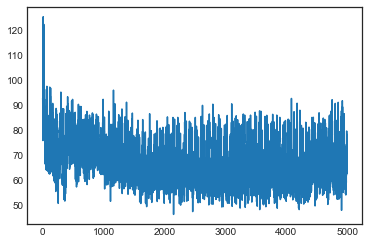

----
 innwyhinn'te u onoe owmevae  wnyTi'h osoravsenllI'lings wwebthele   se onne  yyh  o  Bkesae ool lero 
----
iter 5000, loss 67.059696


In [21]:
while iteration<(numItr+1):
    # Reset
    
    # if the current pointer is outisde the number data points we have +  the step size or this is the first run of the loop
    # initialize the hidden state and c state to zero and make the pointer point to the first character in our
    # dataset
    if pointer + T_steps >= len(data) or iteration == 0:
        g_h_prev = np.zeros((H_size, 1))
        g_C_prev = np.zeros((H_size, 1))
        pointer = 0

    # obtain the T_steps number of character of the input and target values
    inputs = ([char_to_idx[ch] 
               for ch in data[pointer: pointer + T_steps]])
    targets = ([char_to_idx[ch] 
                for ch in data[pointer + 1: pointer + T_steps + 1]])
    
    # perform back and forwad pass throught through the LSTM with T-steps number of ticks
    loss, g_h_prev = \
        forward_backward(inputs, targets, g_h_prev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001

    # Print every hundred steps
    if iteration % numOfIterToShowProgress == 0:
        update_status(inputs, g_h_prev, numOfCharToGenerate)
    
    # update the parameters
    update_paramters()

    # for visulaization purposes
    plot_iter = np.append(plot_iter, [iteration])
    plot_loss = np.append(plot_loss, [loss])
    
    # increment the datapointer to point to the next T-step as well as the iteration count
    pointer += T_steps
    iteration += 1